# АНСАМБЛИ МОДЕЛЕЙ

In [1]:
# !conda install jupyterthemes

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# from jupyterthemes import jtplot
from sklearn.metrics import auc, roc_curve, roc_auc_score
%matplotlib inline
# jtplot.style()

## Часть 0. Деревья решений

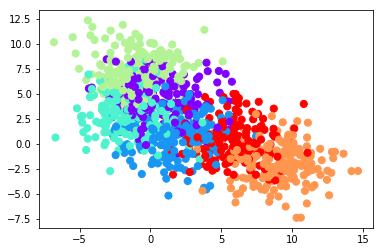

In [2]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=1000, centers=6,
                  random_state=0, cluster_std=2.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow')
plt.show()

In [3]:
def visualize_tree(estimator, X, y, ax=None, fit=True):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='viridis',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    if fit:
        estimator.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    n_classes = len(np.unique(y))
    Z = Z.reshape(xx.shape)
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='viridis',
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

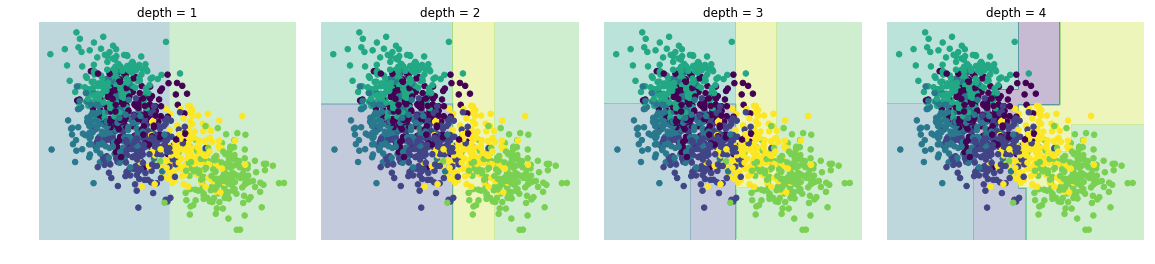

In [4]:
from sklearn.tree import DecisionTreeClassifier
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
fig.subplots_adjust(left=0.02, right=0.98, wspace=0.1)
for axi, depth in zip(ax, range(1, 5)):
    model = DecisionTreeClassifier(max_depth=depth)
    visualize_tree(model, X, y, ax=axi, fit=True)
    axi.set_title('depth = {0}'.format(depth))

### Переобучение деревьев
К сожалению, деревья решений склонны к переобучению. Пример - обучим два дерева решений на половине данных и сравним результаты

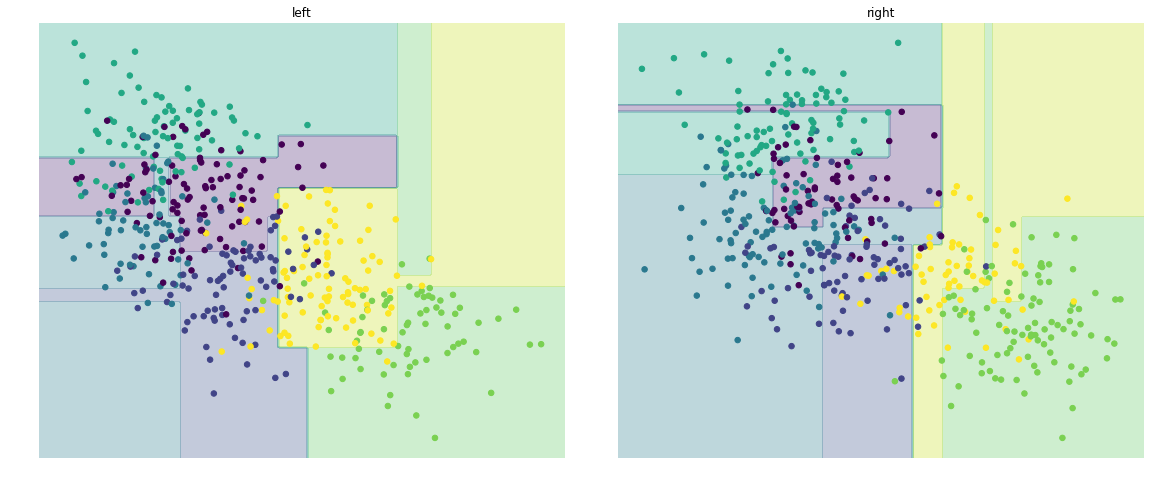

In [5]:
boundary = int(len(X) / 2)
X_left, y_left, X_right, y_right = X[:boundary], y[:boundary], X[boundary:], y[boundary:]

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
fig.subplots_adjust(left=0.02, right=0.98, wspace=0.1)

model_left = DecisionTreeClassifier(max_depth=5)
visualize_tree(model_left, X_left, y_left, ax=ax[0])
ax[0].set_title('left')

model_right = DecisionTreeClassifier(max_depth=5)
visualize_tree(model_right, X_right, y_right, ax=ax[1])
ax[1].set_title('right')
plt.show()

# Часть 1 - Ансамбли

Давайте представим, что для решения задачи бинарной классификации мы вместо одной "хорошей" модели, создали 5 "плохих". Каждая с вероятностью 70% предсказывает правильный ответ и с вероятностью 30% - ошибается. Что если мы заставим эти модели голосовать за результат и будем выбирать предсказание на основе большинства голосов? Увеличиться ли качество модели?

In [6]:
# generate 1000 random numbers (between 0 and 1) for each model, representing 1000 observations
mod1 = np.random.rand(1000)
mod2 = np.random.rand(1000)
mod3 = np.random.rand(1000)
mod4 = np.random.rand(1000)
mod5 = np.random.rand(1000)

# each model independently predicts 1 (the "correct response") if random number was at least 0.3
preds1 = np.where(mod1 > 0.3, 1, 0)
preds2 = np.where(mod2 > 0.3, 1, 0)
preds3 = np.where(mod3 > 0.3, 1, 0)
preds4 = np.where(mod4 > 0.3, 1, 0)
preds5 = np.where(mod5 > 0.3, 1, 0)

# how accurate was each individual model?
print(preds1.mean())
print(preds2.mean())
print(preds3.mean())
print(preds4.mean())
print(preds5.mean())

0.688
0.711
0.701
0.714
0.678


In [7]:
# average the predictions and then round to 0 or 1
ensemble_preds = np.round((preds1 + preds2 + preds3 + preds4 + preds5)/5.0).astype(int)
# how accurate was the ensemble?
# print(ensemble_preds)
print(ensemble_preds.mean())

0.833


### Теорема Кондорсе «о жюри присяжных» (1784).
Если каждый член жюри присяжных имеет независимое мнение, и если вероятность правильного решения члена жюри больше 0.5, то тогда вероятность правильного решения присяжных в целом возрастает с увеличением количества членов жюри и стремится к единице. Если же вероятность быть правым у каждого из членов жюри меньше 0.5, то вероятность принятия правильного решения присяжными в целом монотонно уменьшается и стремится к нулю с увеличением количества присяжных.


$N$ — количество присяжных

$p$ — вероятность правильного решения присяжного

$μ$— вероятность правильного решения всего жюри

$m$ — минимальное большинство членов жюри, $m = \text{floor}(N/2) + 1$

$C^i_N$ - число сочетаний из $N$ по $i$

$$\large \mu = \sum_{i=m}^{N}C_N^ip^i(1-p)^{N-i}$$

Если $p>0.5$, то $\mu>p$

Если $N \rightarrow \infty$, то $\mu \rightarrow 1$

# Часть 2 - Беггинг

Беггинг - общий подход к уменьшению дисперсии алгоритма машинного обучения. Беггинг происходит от фразы bootstrap aggregation. Bootstrap выборка - это просто выборка с повторением

In [45]:
# set a seed for reproducibility
np.random.seed(1)

# create an array of 1 through 20
nums = np.arange(1, 21)
print(nums)

# sample that array 20 times with replacement
print(np.random.choice(a=nums, size=20, replace=True))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 6 12 13  9 10 12  6 16  1 17  2 13  8 14  7 19  6 19 12 11]


Общий алгоритм:
1. Генерируем подвыборку $X_i$ размера $N$ с возвращением
2. Обучим базовый алгоритм $a_i(x)$ на выборке $X_i$
3. Повторяем шаги 1-2 $M$ раз
4. Усредняем (регрессия) или проводим голосование среди ответов $a_i(x)$

Замечания:

- Каждую подвыборку обычно делают размером с оригинальный набор данных
- Количество подвыборок должно быть достаточно, чтобы итоговая ошибка "стабилизировалась"

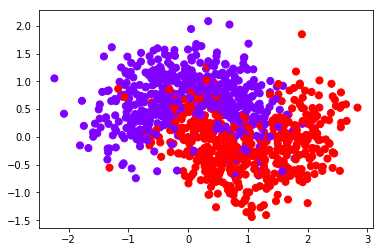

In [46]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, shuffle=True, noise=0.4, random_state=123)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow')
plt.show()

In [47]:
# Поделим на train и тест
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

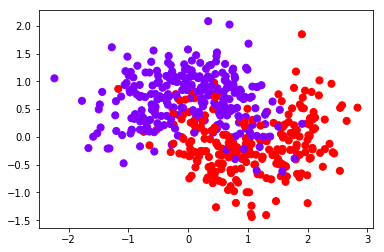

In [48]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=50, cmap='rainbow')
plt.show()

# Практика 1

Реализуйте беггинг над деревьями решений для этого примера (10 деревьев)

# Решение

In [49]:
from sklearn.tree import DecisionTreeClassifier

In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [51]:
depths = np.arange(1,10)
grid = {'max_depth': depths}#, 'max_features': features_num}
gridsearch = GridSearchCV(DecisionTreeClassifier(), grid, cv=5)

In [52]:
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [53]:
max_depth = sorted(gridsearch.grid_scores_, key = lambda x: -x.mean_validation_score)[0][0]['max_depth']
max_depth

C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


5

In [54]:
model = DecisionTreeClassifier(max_depth=5)
model.fit(X_train, y_train)
result = model.predict(X_test)
model.score(X_test, y_test)

0.858

In [55]:
# Z = np.c_[X_train, y_train]
# Zy  = Z[:,-1]
# Zx = Z[:,:-1]
# Zx == X_train;

In [56]:
def bagging_trees (max_depth, X_train, X_test, y_train, y_test, attempt):
    model = DecisionTreeClassifier(max_depth=max_depth)
    prediction = np.zeros(len(X_train))
    array_index = np.arange(0, len(X_train)) 
    for i in range(attempt):   
#         model = DecisionTreeClassifier(max_depth=max_depth)
        rand_index = np.random.choice(a=array_index, size=len(X_train))
        item = model.fit(X_train[rand_index], y_train[rand_index]).predict_proba(X_test)
        prediction += item[:,1]
        print('tree № {}, score {}'.format(i, accuracy_score(np.round(item[:,1]).astype(int), y_test)))
    prediction = np.round(prediction/ attempt).astype(int)
    print('total score- {}'.format(accuracy_score(prediction, y_test)))
    

In [57]:
bagging_trees(max_depth, X_train, X_test, y_train, y_test, 20)


tree № 0, score 0.866
tree № 1, score 0.85
tree № 2, score 0.846
tree № 3, score 0.852
tree № 4, score 0.872
tree № 5, score 0.864
tree № 6, score 0.85
tree № 7, score 0.866
tree № 8, score 0.798
tree № 9, score 0.852
tree № 10, score 0.844
tree № 11, score 0.866
tree № 12, score 0.87
tree № 13, score 0.848
tree № 14, score 0.872
tree № 15, score 0.834
tree № 16, score 0.828
tree № 17, score 0.864
tree № 18, score 0.828
tree № 19, score 0.83
total score- 0.876


###    решение преподавателя

In [58]:
estimators = 10
samples = [np.random.choice(a=X_train.shape[0], size=X_train.shape[0], replace=True) for _ in range(estimators)]

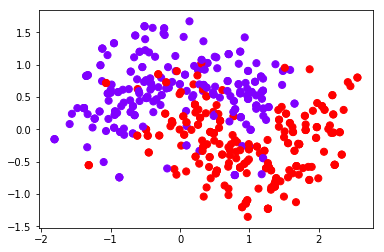

In [59]:
plt.scatter(X_train[samples[3], 0], X_train[samples[3],1], c=y_train[samples[3]], s=50, cmap='rainbow')
plt.show()

In [60]:
models = []
for sample in samples:
    model= DecisionTreeClassifier(max_depth=None)
    model.fit(X_train[sample], y_train[sample])
    models.append(model)

In [61]:
def predict(models, X):
    predictions =None
    for m in models:
        if predictions is None:
            predictions = m.predict(X).reshape((-1, 1))
        else:
            predictions = np.hstack((predictions, m.predict(X).reshape((-1,1))))
    result = []
    for p in predictions:
        result.append(np.bincount(p).argmax())
    return np.array(result)

In [62]:
y_pred = predict(models, X_test)
print(np.mean(y_pred == y_test))
print("MODELS")
for m in models:
    print(np.mean(m.predict(X_test) == y_test))

0.852
MODELS
0.812
0.834
0.816
0.788
0.804
0.806
0.788
0.842
0.806
0.814


# Конец Решения

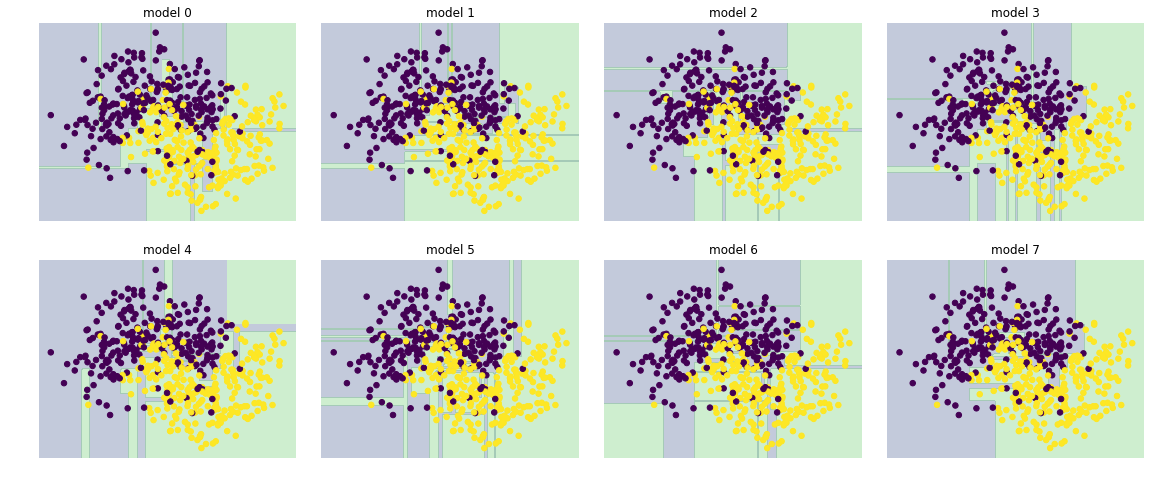

In [63]:
fig, ax = plt.subplots(2, 4, figsize=(16, 8))
fig.subplots_adjust(left=0.02, right=0.98, wspace=0.1)
for axi, index in zip(ax.flatten(), range(8)):
    visualize_tree(models[index], X_train, y_train, ax=axi, fit=False)
    axi.set_title('model {}'.format(index))

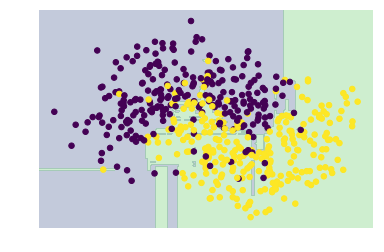

In [64]:
def visualize_bagg(models, X, y):
    ax = plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='viridis',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')

    xlim = ax.get_xlim()    
    ylim = ax.get_ylim()
    
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = predict(models, np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    n_classes = len(np.unique(Z))
    Z = Z.reshape(xx.shape)
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='viridis',
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)
    
visualize_bagg(models, X_train, y_train)

### Практический пример

Используем данные страхового подразделения BNP Paribas из соревнования

https://www.kaggle.com/c/bnp-paribas-cardif-claims-management

Решается задача классификации страховых случаев:

1. Случаи, требующие дополнительных документов для подтвердения (0)    
2. Случаи, которые можно подтверждать автоматически на основе имеющейся информации (1)

In [82]:
data = pd.read_csv('../../../materialii/4._Ensemble/train.csv')

In [83]:
data.head()

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,...,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,...,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,...,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,...,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN


In [84]:
data.shape

(114321, 133)

In [85]:
# Уменьшим размер данных для ускорения обучения, возьмем случайную подвыборку 20% данных
from sklearn.model_selection import StratifiedShuffleSplit

random_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=777)
for train_index, test_index in random_splitter.split(data, data.target):
    data = data.iloc[test_index]
data.shape

(22865, 133)

In [93]:
# Разбиваем на train/test
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=777)

for train_index, test_index in splitter.split(data, data.target):
    d_train = data.iloc[train_index]
    d_test = data.iloc[test_index]
    
    y_train = data['target'].iloc[train_index]
    y_test = data['target'].iloc[test_index]

In [96]:
cat_feat = list(data.dtypes[data.dtypes == object].index)
data[cat_feat] = data[cat_feat].fillna('nan')
num_feat = [f for f in data if f not in (cat_feat + ['ID', 'target'])]


In [97]:
#Находим категориальные признаки
cat_feat = list(data.dtypes[data.dtypes == object].index)

#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
data[cat_feat] = data[cat_feat].fillna('nan')

#отфильтруем непрерывные признаки
num_feat = [f for f in data if f not in (cat_feat + ['ID', 'target'])]

# Смотрим сколько у нас значений по каждому категориальному признаку
cat_nunique = d_train[cat_feat].nunique()
print(cat_nunique)

#Чтобы в разы не увеличивать число признаков при построении dummy,
#будем использовать категориальные признаки с < 30 уникальных значений
cat_feat = list(cat_nunique[cat_nunique < 30].index)

v3         4
v22     6611
v24        5
v30        8
v31        4
v47        9
v52       12
v56       91
v66        3
v71        5
v74        3
v75        4
v79       17
v91        7
v107       7
v110       3
v112      23
v113      35
v125      89
dtype: int64


In [98]:
# Создаем дамми-переменные для категорий
dummy_train = pd.get_dummies(d_train[cat_feat], columns=cat_feat)
dummy_test = pd.get_dummies(d_test[cat_feat], columns=cat_feat)

dummy_cols = list(set(dummy_train) & set(dummy_test))

dummy_train = dummy_train[dummy_cols]
dummy_test = dummy_test[dummy_cols]


# Заменяем пропуски на специальное значение -999, чтобы деревья могли их отличить
X_train = pd.concat([d_train[num_feat].fillna(-999),
                     dummy_train], axis=1)

X_test = pd.concat([d_test[num_feat].fillna(-999),
                     dummy_test], axis=1)

Обучаем решающее дерево

Немного ограничим глубину и минимальное кол-во объектов в листе для уменьшения переобучения

In [99]:
from sklearn.tree import DecisionTreeClassifier

clf_tree = DecisionTreeClassifier(max_depth=15, min_samples_leaf=20)
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [100]:
def show_auc(y, y_pred, plot_label='', prin=True):    
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc_val = auc(fpr, tpr)
    if prin:
        print('ROC AUC: {0:.4f}'.format(auc_val))
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    return auc_val

Train:
ROC AUC: 0.8593
Test:
ROC AUC: 0.6449


0.6448859876665315

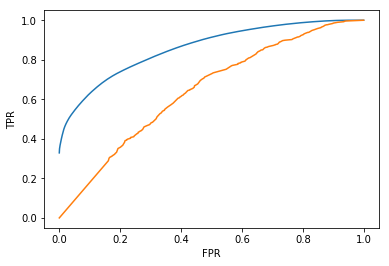

In [101]:
y_pred_test = clf_tree.predict_proba(X_test)[:, 1]
y_pred_train = clf_tree.predict_proba(X_train)[:, 1]

print('Train:')
show_auc(y_train, y_pred_train, 'train')
         
print('Test:')
show_auc(y_test, y_pred_test, 'test')

# Практика 2.

Применить наш беггинг к реальным данным

# Решение

 # Конец решения

### Другой способ
Используем готовый алгоритм из sklearn

In [102]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(n_estimators=20, base_estimator=clf_tree, n_jobs=-1)
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=20, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

Train:
ROC AUC: 0.8934
Test:
ROC AUC: 0.7169


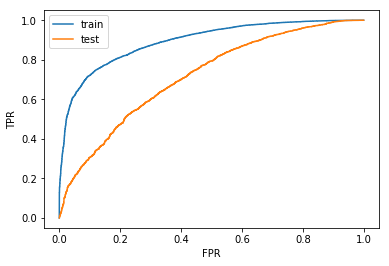

In [103]:
y_pred_test = bag_clf.predict_proba(X_test)[:, 1]
y_pred_train = bag_clf.predict_proba(X_train)[:, 1]

print('Train:')
show_auc(y_train, y_pred_train, 'train')
print('Test:')
show_auc(y_test, y_pred_test, 'test')
plt.legend();

# Часть 3. Случайный лес

Бэггинг + случайные подпространства = случайный лес

Случайный лес - вариация беггинга над деревьями, дающая даже лучшие результаты:
Как и в беггинге, мы создаем ансамбль деревьев решений, используя выборки из обучающего набора.
Однако при построении каждого дерева каждый раз, когда производится расщепление, признак выбирается из случайной выборки размера m из всех признаков.
Новая случайная выборка признаков формируется для каждого отдельного дерева в каждом отдельном расщеплении.
Для классификации $m$ обычно выбирается как квадратный корень из $p$.
Для регрессии $m$ обычно выбирается где-то между $p / 3$ и $p$.

В чем смысл?
Предположим, что в наборе данных есть один очень сильный признак. При использовании беггинга большая часть деревьев будет использовать этот признак в качестве первого, по которому производится деление, в результате чего образуется ансамбль похожих деревьев, которые сильно коррелированы.
Усреднение высококоррелированных величин не приводит к значительному уменьшению дисперсии (что является целью беггинга).
Случайно исключая признаки из каждого расщепления, Random Forest «декоррелирует» деревья, так что процесс усреднения может уменьшить дисперсию результирующей модели.

**Важные гиперпараметры алгоритма**

a. Параметры деревьев
1. criterion - критерий построения дерева
2. max_depth - максимальная глубина дерева (обычно 10-20, больше глубина -> больше риск переобучения)
3. min_samples_leaf - минимальное число объектов в листе (обычно 20+, больше объектов -> меньше риск переобучения)

b. Параметры леса
1. n_estimators - кол-во деревьев (чем больше тем лучше)
2. max_features - число признаков случайного подпространства
3. bootstrap - использовать ли бэггинг
4. n_jobs - кол-во потоков для одновременного построения деревьев (большая прибавка к скорости на многоядерных процах)

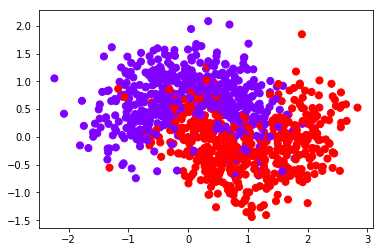

In [104]:
mX, my = make_moons(n_samples=1000, shuffle=True, noise=0.4, random_state=123)

mX_train, mX_test, my_train, my_test = train_test_split(mX, my, test_size=0.3)

plt.scatter(mX[:, 0], mX[:, 1], c=my, s=50, cmap='rainbow')
plt.show()

In [105]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_leaf=20, max_features=0.5, n_jobs=-1)
clf_rf.fit(mX_train, my_train)   

bag_clf = BaggingClassifier(n_estimators=10, base_estimator=DecisionTreeClassifier(), n_jobs=-1)
bag_clf.fit(mX_train, my_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

Train RF:
ROC AUC: 0.9490
Test RF:
ROC AUC: 0.9190
Train RF:
ROC AUC: 0.9993
Test RF:
ROC AUC: 0.9089


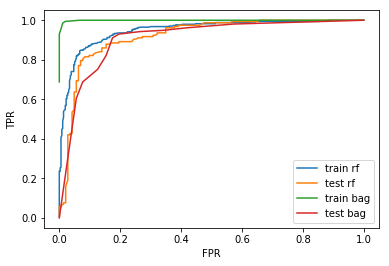

In [106]:
my_pred_test_rf = clf_rf.predict_proba(mX_test)[:, 1]
my_pred_train_rf = clf_rf.predict_proba(mX_train)[:, 1]
my_pred_test_bag = bag_clf.predict_proba(mX_test)[:, 1]
my_pred_train_bag = bag_clf.predict_proba(mX_train)[:, 1]

print('Train RF:')
show_auc(my_train, my_pred_train_rf, 'train rf')
print('Test RF:')
show_auc(my_test, my_pred_test_rf, 'test rf')
print('Train RF:')
show_auc(my_train, my_pred_train_bag, 'train bag')
print('Test RF:')
show_auc(my_test, my_pred_test_bag, 'test bag')

plt.legend();

# Практика 3
Применим случайный лес к нашему dataset'у

In [108]:
X_test.head()

,v1,v2,v4,v5,v6,v7,v8,v9,v10,v11,...,v52_K,v74_B,v107_G,v75_D,v79_H,v71_C,v75_B,v3_B,v79_O,v112_A
56999,2.827512,5.397532,4.344254,6.899799,2.860262,2.401746,0.090904,9.723757,1.838074,15.871965,...,0,1,0,1,0,0,0,0,0,0
27843,2.021857,12.008587,4.714448,6.940149,2.452944,3.351548,0.077961,9.836065,0.109409,15.585997,...,0,1,0,1,0,0,0,0,0,0
63120,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,1.291028,-999.000000,...,0,1,0,0,0,0,1,0,0,0
78440,1.429545,5.885115,2.594627,7.909851,2.799999,1.104545,2.073832,8.025750,6.542669,17.145470,...,0,1,0,0,0,0,1,0,0,0
105923,0.674772,11.691226,4.856090,8.556751,2.285714,4.376900,3.540228,8.054300,0.503281,13.523035,...,0,1,0,0,0,0,1,0,0,0


In [109]:
str_rf = RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_leaf=20, max_features=0.5, n_jobs=-1)
str_rf.fit(X_train, y_train)   
str_bag = BaggingClassifier(n_estimators=10, base_estimator=DecisionTreeClassifier(), n_jobs=-1)
str_bag.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

Train RF:
ROC AUC: 0.7523
Test RF:
ROC AUC: 0.7255
Train Bag:
ROC AUC: 0.9992
Test Bag:
ROC AUC: 0.6672


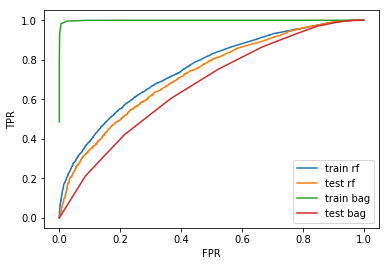

In [110]:
str_pred_test_rf = str_rf.predict_proba(X_test)[:, 1]
str_pred_train_rf = str_rf.predict_proba(X_train)[:, 1]
str_pred_test_bag = str_bag.predict_proba(X_test)[:, 1]
str_pred_train_bag = str_bag.predict_proba(X_train)[:, 1]

print('Train RF:')
show_auc(y_train, str_pred_train_rf, 'train rf')
print('Test RF:')
show_auc(y_test, str_pred_test_rf, 'test rf')
print('Train Bag:')
show_auc(y_train, str_pred_train_bag, 'train bag')
print('Test Bag:')
show_auc(y_test, str_pred_test_bag, 'test bag')

plt.legend();

# Практика Решение

## Решение конец

#### Важность признаков
В sklearn - усредненное по всем деревьям в ансамбле кол-во сплитов по признаку, взвешенное на прирост информации (Information gain) и долю объектов в вершине, в которой производится этот сплит

Это не единственный вариант, см здесь:

https://medium.com/@ceshine/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3

Важности признаков случайного леса лежат в артибуте **feature\_importances\_**

In [111]:
imp = pd.Series(str_rf.feature_importances_)
imp.sort_values(ascending=False)

43     0.463358
185    0.099575
153    0.060962
149    0.060660
129    0.052327
135    0.028634
109    0.026541
10     0.020427
207    0.018133
34     0.015862
191    0.014328
180    0.011692
8      0.010711
28     0.009635
95     0.009017
170    0.006573
198    0.006248
51     0.003592
30     0.003417
48     0.003311
7      0.002678
58     0.002560
3      0.002538
193    0.002369
111    0.002367
37     0.002173
143    0.002107
96     0.002047
69     0.001905
173    0.001901
         ...   
221    0.000000
108    0.000000
104    0.000000
103    0.000000
102    0.000000
99     0.000000
127    0.000000
131    0.000000
158    0.000000
132    0.000000
157    0.000000
156    0.000000
155    0.000000
154    0.000000
152    0.000000
151    0.000000
150    0.000000
148    0.000000
147    0.000000
146    0.000000
142    0.000000
141    0.000000
140    0.000000
139    0.000000
138    0.000000
137    0.000000
136    0.000000
134    0.000000
133    0.000000
0      0.000000
Length: 223, dtype: floa

Плюсы random_forest:
- устойчив к переобучению
- устойчивость к выбросам
- дает хорошее качество “из коробки”
- встроенная оценка важности признаков
- быстрая реализация

Минусы:
- сложность интерпретации по сравнению с одним деревом
- плохо справляется с очень большим числом признаков
- работает дольше линейных моделей

# Часть 4. Композиции моделей разных типов

Главная идея - почему ансамблирование моделей делается таким простым способом, как усреднение? Что если доверить это делому другому алгоритму машинного обучения?

## Блендинг
<img src="img/stacking.png" style="max-width: 680px; display: inline" />

Основной недостаток - деление обучающей выборки. Никакой из алгоритмов не использует всех данных для обучения.

## Стекинг

Используем идею K-Fold проверки. Выборку разбиваем на фолды, затем последовательно перебираем фолды и обучаем базовые алгоритмы на всех фолдах, кроме одного, а на оставшемся получаем ответы базовых алгоритмов и трактуем их как значения соответствующих признаков на этом фолде. Для получения метапризнаков объектов тестовой выборки базовые алгоритмы обучают на всей обучающей выборке и берут их ответы на тестовой.

<img src="img/stacking-2b.png" style="max-width: 680px; display: inline" />

### Практика

Смешаем дерево и логистическую регрессию

**Создаем признакии**

1. Заменяем пропуски на медианы
2. Создаем индикаторы пропущенных значений
3. Создаем дамми-переменные для категорий
4. Нормируем признаки

### Обучим логистическую регрессию

In [112]:
from sklearn.preprocessing import StandardScaler

train_median = d_train[num_feat].median()

X_train_lin = pd.concat([d_train[num_feat].fillna(train_median),
                     d_train[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_train], axis=1)

X_test_lin = pd.concat([d_test[num_feat].fillna(train_median),
                     d_test[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_test], axis=1)

scaler = StandardScaler()
scaler.fit(X_train_lin[num_feat])

X_train_lin[num_feat] = scaler.transform(X_train_lin[num_feat])
X_test_lin[num_feat] = scaler.transform(X_test_lin[num_feat])

In [113]:
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression(penalty='l1', C=0.1)

clf_lr.fit(X_train_lin, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Train:
ROC AUC: 0.7324
Test:
ROC AUC: 0.7240


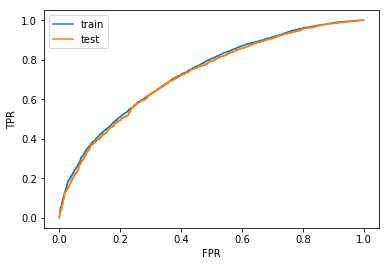

In [114]:
y_pred_lin_test = clf_lr.predict_proba(X_test_lin)[:, 1]
y_pred_lin_train = clf_lr.predict_proba(X_train_lin)[:, 1]

print('Train:')
show_auc(y_train, y_pred_lin_train, 'train')
print('Test:')
show_auc(y_test, y_pred_lin_test, 'test')
plt.legend();

Будем строить линейную комбинацию логистической регрессии и случайного леса вида 

$y = \alpha y_1 + (1 - \alpha) y_2$

Параметр $\alpha$ переберем по сетке от 0 до 1, оценивая качество на тестовой выборке

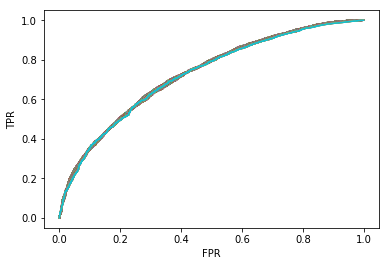

In [115]:
aucs = []
alpha_space = np.linspace(0, 1, 100)
for alpha in alpha_space:
    y_pred_weight = alpha * y_pred_lin_test + (1 - alpha) * str_pred_test_rf
    aucs.append(show_auc(y_test, y_pred_weight, prin=False, plot_label=str(alpha)))
aucs = np.array(aucs)    

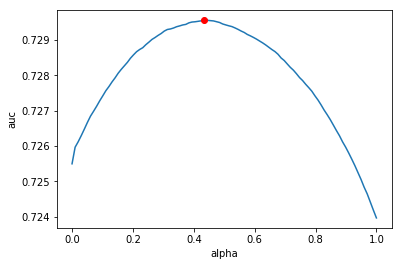

In [116]:
max_ind = np.where(aucs == aucs.max())[0]
alpha = alpha_space[max_ind]

plt.plot(alpha_space, aucs)
plt.plot(alpha_space[max_ind], aucs[max_ind], 'o', c='r')
plt.xlabel('alpha')
plt.ylabel('auc')

#итоговое взвешенное предсказание
y_pred_weight = alpha * y_pred_lin_test + (1 - alpha) * str_pred_test_rf

Сравним 3 метода (приблизим график ROC кривой, чтобы увидеть разницу)

Weighted:
ROC AUC: 0.7296
Log regression:
ROC AUC: 0.7240
Random forest:
ROC AUC: 0.7255


(0.5, 0.8)

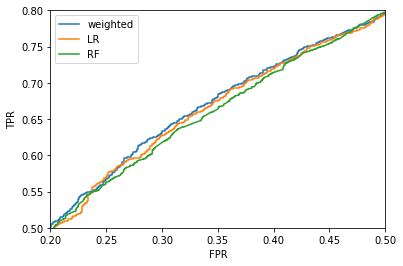

In [117]:
print('Weighted:')
show_auc(y_test, y_pred_weight, 'weighted')
print('Log regression:')
show_auc(y_test, y_pred_lin_test, 'LR')
print('Random forest:')
show_auc(y_test, str_pred_test_rf, 'RF')
plt.legend();
plt.xlim(0.2, 0.5)
plt.ylim(0.5, 0.8)

### Попробуем стекинг

In [126]:
def get_meta_features(clf, X_train, y_train, X_test, stack_cv):
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_test = np.zeros_like(y_test, dtype=float)
    
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)):
        
        clf.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
        meta_train[test_ind] = clf.predict_proba(X_train.iloc[test_ind])[:, 1]
        meta_test += clf.predict_proba(X_test)[:, 1]
    
    return meta_train, meta_test / stack_cv.n_splits

In [129]:
meta_train = np.zeros_like(y_train, dtype=float)
meta_test = np.zeros_like(y_test, dtype=float)

for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)):

    clf_lr.fit(X_train_lin.iloc[train_ind], y_train.iloc[train_ind])
    print(clf_lr.predict_proba(X_train_lin.iloc[test_ind])[:, 1])
    meta_test += clf_lr.predict_proba(X_test_lin)[:, 1]

[0.94442576 0.42628028 0.98092205 ... 0.78728736 0.83794622 0.91072811]
[0.63163667 0.5256265  0.85022965 ... 0.71717407 0.82446333 0.60801139]
[0.59071238 0.78562375 0.43988804 ... 0.82693727 0.98665297 0.94141994]
[0.79199586 0.8429133  0.70963359 ... 0.9273224  0.7385544  0.64931363]
[0.84855899 0.74060895 0.5379794  ... 0.49383803 0.72068956 0.55936655]
[0.88275044 0.98068806 0.77935851 ... 0.46161243 0.80523184 0.85832707]
[0.74225923 0.77066648 0.95168691 ... 0.49484756 0.8021601  0.74750333]
[0.97010414 0.66236652 0.90182108 ... 0.93375366 0.89634534 0.68504883]
[0.86377654 0.64100618 0.95272789 ... 0.55928571 0.85306    0.92643741]
[0.86834592 0.58550471 0.88452379 ... 0.62817899 0.90335993 0.8822779 ]


In [131]:
from sklearn.model_selection import StratifiedKFold

stack_cv = StratifiedKFold(n_splits=10, random_state=555)

meta_train = []
meta_test = []
col_names = []

print('LR features...')
meta_tr, meta_te = get_meta_features(clf_lr, X_train_lin, y_train, X_test_lin, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('lr_pred')

print('RF features...')
meta_tr, meta_te = get_meta_features(clf_rf, X_train, y_train, X_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('rf_pred')

LR features...
RF features...


In [132]:
for i in meta_train:
    print(np.array(i).shape)

(16005,)
(16005,)


In [120]:
X_meta_train = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names)
X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names)

In [121]:
X_meta_train.head()

,lr_pred,rf_pred
0,0.939733,0.964300
1,0.357235,0.508101
2,0.962645,0.914325
3,0.910615,0.905908
4,0.644471,0.732850


In [122]:
X_meta_test.head()

,lr_pred,rf_pred
0,0.669809,0.631948
1,0.721358,0.670610
2,0.903882,0.851294
3,0.784608,0.770335
4,0.697084,0.627959


#### Стэкинг мета-признаков с помощью LR
Используем регуляризованную лог регрессию в качестве алгоритма второго уровня

In [123]:
clf_lr_meta = LogisticRegression(penalty='l2', C=1)
clf_lr_meta.fit(X_meta_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

ROC AUC: 0.7314


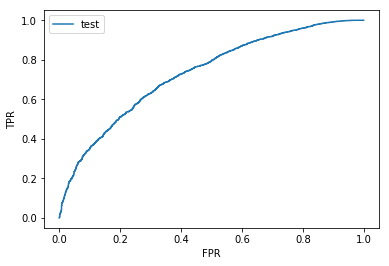

In [124]:
y_pred_meta_test = clf_lr_meta.predict_proba(X_meta_test)[:, 1]

show_auc(y_test, y_pred_meta_test, 'test')
plt.legend();

#### Посмотрим на коэффициенты объединяющей линейной модели

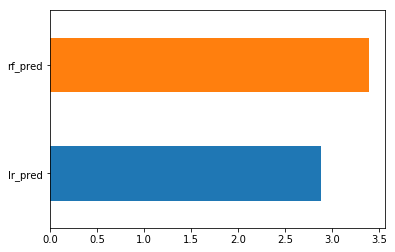

In [125]:
pd.Series(clf_lr_meta.coef_.flatten(), index=X_meta_train.columns).plot(kind='barh')

# Домашняя работа

1. Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
2. Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
3. Построить случайный лес, вывести важность признаков
4. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
5. Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
6. Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
7. В качестве решения:
    Jupyter notebook с кодом, комментариями и графиками